When adversarial examples were first discovered by Szegedy in 2013, the optimization problem to craft adversarial examples was formulated as:

![](https://drive.google.com/uc?export=view&id=1FIHFqZ2V4hwnd8cl7r-Pc54322PN2HZ5)

where, x= input image, 𝛿 = perturbations, D = distance metric between the adversarial and real image, C = Classifier function, n= dimensions, t = target class. The distance metric is usually specified in terms of Lp norms (L0, L2 or L∞). Constraint 1 makes sure that the image is indeed misclassified and constraint 2 makes sure that the adversarial image is valid i.e. it lies within the normalized dimensions of x.

Traditionally well known way to solve this optimization problem is to define an objective function (**generally but not necessarily a loss function that penalizes as we move further from satisfying the constraints**) and to perform gradient descent on it; which guides us to a optimal point in the function. However, The formulation above is difficult to solve because C ( x + 𝛿 ) = t is highly non-linear (the classifier is not a straight forward linear function). In the work by Szegedy in 2013, he resorts to solving the problem approximately, using 2nd order optimization technique known as L-BFGS.

But In C&W attack, Carlini expresses constraint 1 in a different form as an objective function ‘f’ (the reasoning behind this is that this form is suited better for optimization) such that when C ( x + 𝛿 ) = t is satisfied f ( x + 𝛿 ) ≤ 0 is also satisfied

Conceptually, the objective function tells us “how close we are getting to being classified as t”. One simple example fo the function ‘f’, one that is not a very good choice but is well suited for explanation is:

f = [1 - C(x+δ)T]

Where C( x + 𝛿 )T is the probability of x+ 𝛿 being classified as t. If the probability is low, value of f is closer to 1 whereas when it is classified as t, f is equal to 0

Some of the caveats of the C&W attack are:

1) This attack algorithm can generate stronger/ higher quality adversarial examples but the cost to generate them is also higher (because of the way optimization problem is formulated). Even though, Carlini suggests some relaxations in the paper to reduce the cost, it is still costly.

2) Compared to attack techniques like the Fast Gradient Sign Method (FGSM), another major difference here is that in the original formulation of the C&W attack problem, the authors do not specify a threshold that sets a limits the maximum distortion that is allowed. This is done in FGSM with a parameter ‘ellipson’. What this means is that, the attack here always succeeds.

Carlini showed that adversarial examples are classified with a higher confidence than real images for C&W attack. This might be true for other attack algorithms as well.

![](https://drive.google.com/uc?export=view&id=1ZAo8mxs-1klCKTLLdt8U7a7mvbxiErHJ)


In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

import matplotlib
import datetime
import time as t

import matplotlib
import tkinter
from tkinter import ttk
import threading
import tensorflow as tf
import numpy as np
from PIL import ImageTk, Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
def loss(model, perturbated_image, target):
    """
    This method is used to calculate the loss function specified by carlini and wagner to be the most promising
    to use for this attack.
    :param model: attacked model
    :param perturbated_image: adversarial example
    :param target: target class the perturbated_image should be misclassified as.
    :return: loss value
    """
    # model(perturbated_image) returns [output, output_pre_activation] with output and output_pre_activation
    # of shape [1 1000], so indexing by [1][0] returns output_pre_activation in shape [1000]
    output_pre_activation = model(perturbated_image)[1][0]
    max_z = tf.reduce_max(output_pre_activation)
    z_t = output_pre_activation[target]
    return tf.maximum(0.0, max_z - z_t)


def load_and_format_image(path, size):
    """
    This method is used to load the image stored at path, scale it to size and to pixel values in [0,1],
    and converting it to a tf.Tensor with format NHWC.
    :param path: The path the image to be loaded is stored.
    :param size: The 2-dim. size of the image. An 224 by 224 rgb image has size (224,224) for example.
    :return: formatted and rescaled image as NHWC tensor
    """
    image = tf.keras.preprocessing.image.load_img(path)
    image = image.resize(size)
    preprocessed_img = tf.keras.preprocessing.image.img_to_array(image)
    # the carlini-wagner attack generates images with values in [0,1], so the loaded image with values in
    # {0,1,..,255} needs to be rescaled
    preprocessed_img = preprocessed_img / 255.0
    preprocessed_img = tf.reshape(preprocessed_img, shape=(1,
                                                           preprocessed_img.shape[0],
                                                           preprocessed_img.shape[1],
                                                           preprocessed_img.shape[2]))
    return preprocessed_img


def preprocess_model(model):
    """
    The carlini-wagner attack relies on having an option to obtain the logits that serve as input to the
    softmax layer, so the last layer of the model has to be split.
    """
    model.layers[-1].activation = tf.identity
    inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')
    # As the carlini wagner attack considers images to have pixel values in [0,1], but most image processing models
    # use 8-bit color channels, we need to rescale by a factor of 255.
    inputs_scaled = inputs * 255
    output_pre_softmax = model(inputs_scaled)
    #use softmax as this function was the best as said by carlini
    output = tf.nn.softmax(output_pre_softmax)
    return tf.keras.Model(inputs=inputs, outputs=[output, output_pre_softmax])


def perform_iteration(opt, model, input_img, target, w, c):
    """
    This method implements a single update step using the optimizer opt, given the model, input image, target,
    the learnable perturbation matrix w and the tradeoff variable c.
    :w is learnable perturbation value
    :c is tradeoff between distance and loss. High c means higher success rate, lower c means increased quality of
              adversarial example
    """
    with tf.GradientTape() as tape:
        tape.watch(w)
        delta = (1 / 2) * (tf.tanh(w) + 1) - input_img
        loss_pre_softmax = loss(model, input_img + delta, target)
        loss_distance = tf.norm(delta, ord='euclidean')
        total_loss = loss_distance + c * tf.dtypes.cast(loss_pre_softmax, tf.dtypes.float32)
    gradients = tape.gradient(total_loss, w)
    opt.apply_gradients(zip([gradients], [w]))
    return total_loss, loss_pre_softmax


def to_img(input_image, w):
    """
    This method is used to generate an image with pixel values in {0,1,..,255} represented as 4d np.ndarray.
    """
    delta = (1 / 2) * (tf.tanh(w) + 1) - input_image
    output_img = input_image + delta
    image_shape = (-1, input_image.shape[1], input_image.shape[2], input_image.shape[3])
    output_img_rescaled = output_img * 255
    return np.uint8(np.reshape(output_img_rescaled.numpy(), image_shape))


def summary_entry(file_writer, epoch, input_image, w, misclassification_loss, loss_val):
    with file_writer.as_default():
        if epoch % 100 == 0:
            # to save disk space only every 100 steps a image is written to the summary
            tf.summary.image("Perturbated Image", to_img(input_image, w), step=epoch)
        tf.summary.scalar("Misclassification Loss", misclassification_loss, step=epoch)
        tf.summary.scalar("Total Loss", loss_val, step=epoch)


def perform_attack(model, input_image, target, epochs=2500, c=1, tb=True, tb_path='./logs/cw'):
    """
    carlini-wagner attack.Return: np.ndarray with pixel values in {0,1,...,255}
    """
    # w is the parameter on which we perform learning steps, see to_img(input_image, w) to see how perturbation works.
    w = tf.Variable(tf.zeros(tf.shape(input_image)), dtype=tf.dtypes.float32)
    optimizer = tf.keras.optimizers.Adam()
    file_writer = tf.summary.create_file_writer(tb_path)

    for epoch in tqdm(range(epochs)):
        loss_val, misclassification_loss = perform_iteration(optimizer, model, input_image, target, w, c)
        if tb:
            summary_entry(file_writer, epoch, input_image, w, misclassification_loss, loss_val)

    return to_img(input_image, w)[0]

In [ ]:
class AdversarialAttack:
    """
    This class serves as a wrapper class for easier access to the cw attack
    """

    def __init__(self, **kwargs):
        self.model = kwargs['model']
        # set selected algorithm to one of  {fast_gradient_sign_method, carlini_wagner, one_pixel_attack}
        attack_algorithm_name = kwargs['attack_algorithm']

        
        # the carlini wagner attack relies on using logits, so the softmax layer has to be split
        self.model = preprocess_model(self.model)

    def load_and_format_img(self, path, size):
       
        return load_and_format_image(path, size)

    def perform_attack(self, input_image, *args, **kwargs):
       
        return perform_attack(self.model, input_image, *args, **kwargs)

    def save_img_with_timestamp(image, directory, name=""):
        """
        This method can be used to save images with a timestamp included in the filename.
        """
        timestamp = datetime.datetime.fromtimestamp(t.time()).strftime('%Y_%m_%d_%H_%M_%S')
        # add an underscore if a name was given, to make it easier to read
        name = name if name == '' else name + '_'
        matplotlib.image.imsave('{}/{}{}.png'.format(directory, name, timestamp), image)

In [ ]:
def labels_and_probabilities(model,image):
        """
        Returns labels and self.net's corresponding estimated probabilities.
        :param image: image for which probabilities should be estimated.
        :return: list of labels and list of corresponding probabilities.
        """
        predictions = [(label, probability) for _, label, probability in
                       decode_predictions(model.predict(image), top=10)[0]]
        labels = [a for a, _ in predictions]
        probabilities = [b for _, b in predictions]
        return labels, probabilities


def display_barh(model, labels, probabilities):

        fig, ax = plt.subplots(figsize=(7, 4.5), dpi=75)

        y_pos = np.arange(len(labels))

        ax.barh(y_pos, probabilities, align='center', color='blue')
        ax.set_yticks(y_pos)

        ax.set_yticklabels(labels)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Probability\n')
        ax.set_title('Estimation of VGG16')
        plt.show()

def _load_and_format_image(path, size):
        """
        This method is used to load the image stored at path, scale it to size and to pixel values in [0,1],
        and converting it to a tf.Tensor with format NHWC.
        :param path: The path the image to be loaded is stored.
        :param size: The 2-dim. size of the image. An 224 by 224 rgb image has size (224,224) for example.
        :return: formatted and rescaled image as NHWC tensor
        """
        image = tf.keras.preprocessing.image.load_img(path)
        image = image.resize(size)
        preprocessed_img = tf.keras.preprocessing.image.img_to_array(image)
        preprocessed_img = tf.reshape(preprocessed_img, shape=(1,
                                                              preprocessed_img.shape[0],
                                                              preprocessed_img.shape[1],
                                                              preprocessed_img.shape[2]))
        return preprocessed_img

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf



model = tf.keras.applications.VGG16()
[(_, height, width, _)] = model.layers[0].input_shape
size = height, width


path = '/content/drive/MyDrive/Thesis_notebooks/keras_boundary_attack/images/2.png'
aa = AdversarialAttack(attack_algorithm='carlini_wagner', model=model)
input_image = aa.load_and_format_img(path, size)
# target 291 meaning the target class is the lion, see: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
adv_img = aa.perform_attack(input_image, target=291, epochs=1000, tb_path='./logs/cw/sea_lion/')
aa.save_img_with_timestamp(adv_img, directory='/content/drive/MyDrive/Thesis_notebooks/Carlini_Wagner/images', name='mnist_adve')
    

100%|██████████| 1000/1000 [21:07<00:00,  1.27s/it]


['lion', 'hyena', 'warthog', 'Irish_setter', 'volcano', 'cougar', 'fire_screen', 'dhole', 'red_wolf', 'cheetah']


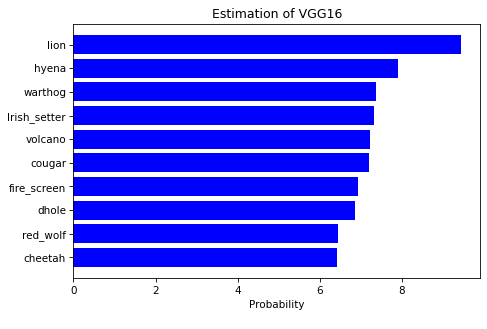

In [ ]:
a_path = '/content/drive/MyDrive/Thesis_notebooks/Carlini_Wagner/images/mnist_adve_2022_09_21_10_58_03.png'
a_image = _load_and_format_image(a_path, size)
labels, probabilities = labels_and_probabilities(model,a_image)
print(labels)
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=75)

y_pos = np.arange(len(labels))

ax.barh(y_pos, probabilities, align='center', color='blue')
ax.set_yticks(y_pos)

ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability\n')
ax.set_title('Estimation of VGG16')
plt.savefig("mygraph.png")

['analog_clock', 'matchstick', 'hair_slide', 'digital_clock', 'pick', 'safety_pin', 'dragonfly', 'screw', 'maraca', 'hook']


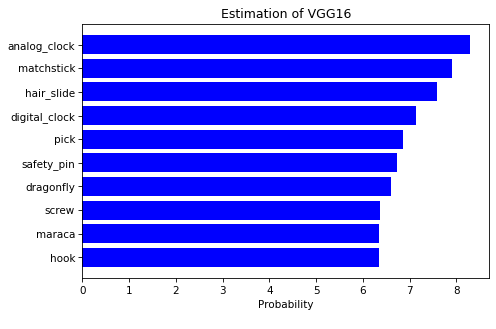

In [ ]:
b_image = _load_and_format_image(path, size)
labels, probabilities = labels_and_probabilities(model,b_image)
print(labels)
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=75)

y_pos = np.arange(len(labels))

ax.barh(y_pos, probabilities, align='center', color='blue')
ax.set_yticks(y_pos)

ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability\n')
ax.set_title('Estimation of VGG16')
plt.savefig("mygraph_or.png")